In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_27337/2889067548.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
# Importing Required Libraries

# Import the MNIST dataset from torchvision
import torchvision

# Import numpy for data manipulation
import numpy as np

# Load the MNIST dataset and download it if necessary
MNIST = torchvision.datasets.MNIST(".", download=True)

# Extract the training data, training labels, test data, and test labels from the MNIST dataset
train_data = MNIST.train_data
train_labels = MNIST.train_labels
test_data = MNIST.test_data
test_labels = MNIST.test_labels

# Combining and Subsampling Data

# Vertically combine the training and test data arrays
data = np.vstack([train_data, test_data])

# Vertically combine the training and test labels arrays
labels = np.hstack([train_labels, test_labels])

# Set a random seed for reproducibility
np.random.seed(42)

# Randomly select 20,000 samples from the combined data without replacement
indices = np.random.choice(len(data), size=20000, replace=False)

# Update the 'data' array to include only the selected samples
data = data[indices]

# Update the 'labels' array to include only the labels corresponding to the selected samples
labels = labels[indices]

# Reshape the 'data' array to ensure it is a 2D array
data = data.reshape(data.shape[0], -1)

# Explanation:
# This code imports the MNIST dataset using torchvision and extracts the training and test data along with their labels.
# It then vertically combines the training and test data arrays, as well as the labels arrays, to create a larger dataset.
# Randomly, 20,000 samples are selected from the combined dataset without replacement to reduce its size.
# Finally, both the 'data' and 'labels' arrays are reshaped into 2D arrays, which is a common format for input to machine learning models.


/home/yifei/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/yifei/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/yifei/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/yifei/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [3]:
# Set a random seed for reproducibility
np.random.seed(42)

# Randomly select 20,000 samples from the combined data without replacement
indices = np.random.choice(len(data), size=20000, replace=False)

# Update the 'data' array to include only the selected samples
data = data[indices]

# Update the 'labels' array to include only the labels corresponding to the selected samples
labels = labels[indices]

# Reshape the 'data' array to ensure it is a 2D array
data = data.reshape(data.shape[0], -1)

# Reshape the 'labels' array to ensure it is a 2D array
labels = labels.reshape(labels.shape[0], -1)

# Explanation:
# This code combines the training and test datasets and labels to create a larger dataset for analysis.
# It then randomly selects 20,000 samples from the combined dataset without replacement, ensuring randomness and diversity.
# The 'data' and 'labels' arrays are updated to contain only the selected samples.
# Finally, both the 'data' and 'labels' arrays are reshaped into 2D arrays, which is a common format for input to machine learning models.


In [4]:
data = np.concatenate((labels, data),axis=1)

In [5]:
# import dataset (comes with colab!)


# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# Create train/test groups using DataLoader

In [6]:
# convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()



# boolean vector with the 7's
where7 = labels==7

# separate data into tensors with, and without, 7's
dataNo7   = dataT[~where7,:]
labelsNo7 = labelsT[~where7]
data7     = dataT[where7,:] 
# don't need the labels! ;)



# convert into PyTorch Datasets
train_data = TensorDataset(dataNo7,labelsNo7)
test_data  = TensorDataset(data7)

# translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [7]:
# confirm that the separation is accurate
np.unique(labelsNo7)

array([0, 1, 2, 3, 4, 5, 6, 8, 9])

# Create the DL model

In [8]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10) # NOTE: still 10 outputs, but output #7 is never trained

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NOTE: log-softmax output for later inspection
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

# Create a function that trains the model

In [9]:
# a function that trains the model

# NOTE: anything test-related can be deleted!

def function2trainTheModel():

  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)
  # end epochs

  # function output
  return trainAcc,losses,net


# Run the model and show the results!

In [10]:
trainAcc,losses,net = function2trainTheModel()


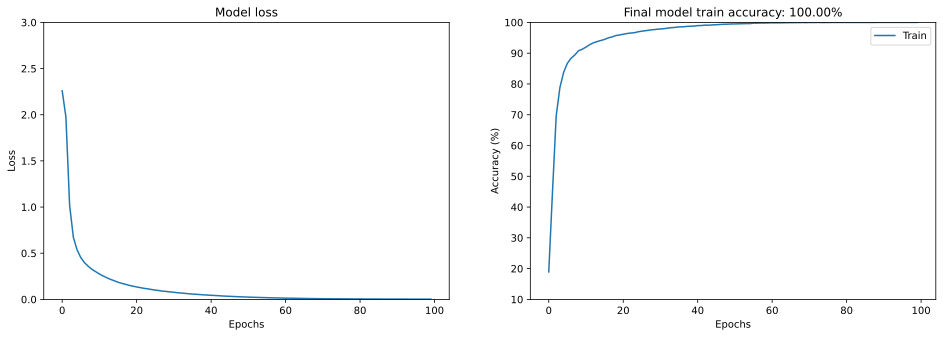

In [11]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model train accuracy: {trainAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Now for the mystery test!

In [12]:
# run the model through for the test data
X = next(iter(test_loader))[0] # note: only need one output, hence the [0]
predictions = net(X).detach()

# save the model guesses
guesses = torch.argmax(predictions,axis=1).detach()

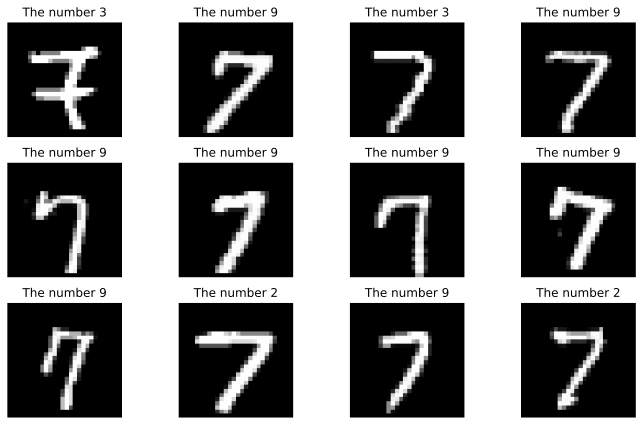

In [18]:
# show some 7's and their labels

fig,axs = plt.subplots(3,4,figsize=(10,6))

someRandom7s = np.random.choice(len(X),12)

for i,ax in enumerate(axs.flatten()):

  thisimg = X[ someRandom7s[i] ].view(28,28)
  ax.imshow(thisimg,cmap='gray')
  ax.set_title(f'The number {guesses[ someRandom7s[i] ]}')
  ax.axis('off')

plt.tight_layout()
plt.show()

[0 1 2 3 4 5 8 9]


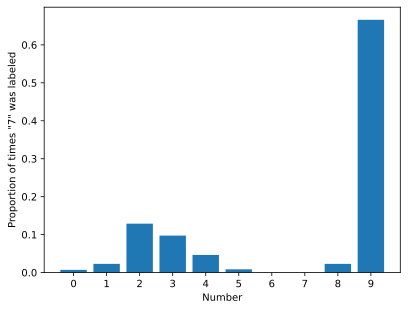

In [14]:
# which numbers are most likely to be confused with 7?
print( np.unique(guesses) )

probMistaken = np.zeros(10)

for i in range(10):
  probMistaken[i] = torch.mean((guesses==i).float())

plt.bar(range(10),probMistaken)
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Proportion of times "7" was labeled')
plt.show()

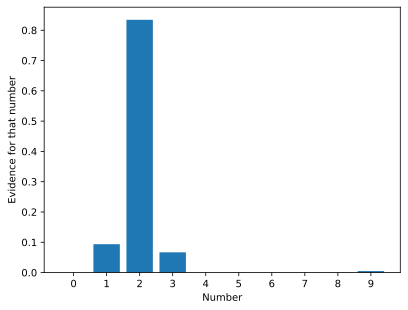

In [20]:
# Evidence for all numbers from one sample
sample2show = 39

plt.bar(range(10),torch.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.show()

# Additional explorations

In [16]:
# 1) In the image matrix we created above, we picked random 7's and showed their labels. Create another image
#    matrix to show all of the times that a 7 was labeled "0". How do those 7's look? You can re-run this for
#    the other numbers.
# 
# 2) It's not surprising that most of the 7's were labeled as "9". You can now repeat this code file with other numbers
#    left out. What other pair of numbers do you expect to be commonly misclassified based on typographical similarity?
# 
# 3) Add dropout regularization to fc1 and fc2 (what else do you need to modify in the code to make sure the dropout
#    is applied only during training?). Does that affect how the model categorizes 7's?
# 